In [1]:
import torch
from model.encoder import Encoder
from model.self_interaction import SelfInteraction
from model.cross_interaction import CrossInteraction
from PIL import Image
import PIL
from matplotlib import pyplot as plt
from torchvision import transforms
import numpy as np
plt.rcParams['figure.figsize'] = (15.0, 15.0)

In [18]:
def draw_init(img_path,sk_path):
    img=Image.open(img_path).resize((512,512))
    sk=Image.open(sk_path).resize((512,512))
    img=np.array(img)
    sk = sk.split()[3]
    sk = Image.merge('RGB', (sk, sk, sk))
    sk=PIL.ImageOps.invert(sk)
    sk=np.array(sk)
    board=np.ones((512,1062,3),dtype=np.uint8)*255
    board[:,:512,:]=sk
    board[:,550:,:]=img
    return board

def draw_arrow(ax,arrow_index):
    a_x=(arrow_index[0]%16)*32+16
    a_y=(arrow_index[0]//16)*32+16
    b_x=(arrow_index[1]%16)*32+566
    b_y=(arrow_index[1]//16)*32+16
    ax.arrow(a_x, a_y, b_x-a_x, b_y-a_y, head_width=7.0, fc='r', ec='r')
    ax.arrow(b_x, b_y, a_x-b_x, a_y-b_y, head_width=7.0, fc='r', ec='r')

In [3]:
ckpt_path='/home/xjq/code/shoe/DLI-Net/ckpt/dli-shoe-v2.pth'
img_encoder=Encoder('mid').cuda()
sk_encoder=Encoder('mid').cuda()
ckpt=torch.load(ckpt_path)
img_encoder.load_state_dict(ckpt['encoder_img'])
sk_encoder.load_state_dict(ckpt['encoder_sk'])
self_interaction=SelfInteraction(0.5)
match=CrossInteraction('2norm')

In [49]:
img_path='/home/xjq/code/dataset/qmul_v2/ShoeV2/trainB/1183045057.png'
sk_path='/home/xjq/code/dataset/qmul_v2/ShoeV2/trainA/1183045057_2.png'
norm=transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
input_transform=transforms.Compose([transforms.Resize(256),transforms.ToTensor(), norm])
img=Image.open(img_path)
img_tensor=input_transform(img)
img_tensor=img_tensor.unsqueeze(0).cuda()
sk=Image.open(sk_path)
sk = sk.split()[3]
sk = Image.merge('RGB', (sk, sk, sk))
sk_tensor = input_transform(sk)
sk_tensor=sk_tensor.unsqueeze(0).cuda()

In [50]:
img_fea=img_encoder(img_tensor)
img_fea,img_keep_index=self_interaction.visualize(img_fea)
sk_fea=sk_encoder(sk_tensor)
sk_fea,sk_keep_index=self_interaction.visualize(sk_fea)
dis,match_index=match.visualize(img_fea,sk_fea)
dis=dis[:,0,0].cpu()
_,dis_index=torch.sort(dis)
img_keep_index=img_keep_index[0].cpu()
sk_keep_index=sk_keep_index[0].cpu()
match_index=match_index[:,0,0].cpu()
arrow_index=[]
for sk_index in dis_index[:32]:
    arrow_index.append((sk_keep_index[sk_index],img_keep_index[match_index[sk_index]]))

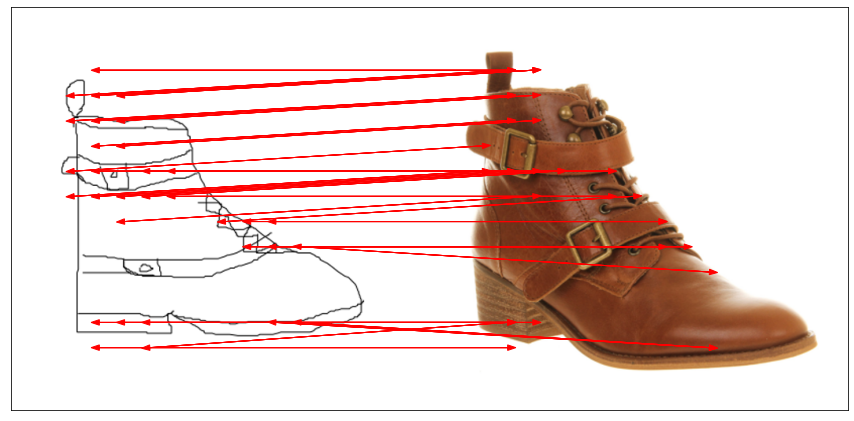

In [51]:
board=draw_init(img_path,sk_path)
ax=plt.axes()
ax.imshow(board)
plt.xticks([])
plt.yticks([])
for index in arrow_index:
    draw_arrow(ax,index)
plt.savefig('./cross_interaction.svg')
plt.show()